# Imports

In [ ]:
from ultralytics import YOLO
import os
from azure.storage.blob import BlobServiceClient
from pydicom import dcmread
from io import BytesIO
import numpy as np
import cv2
import pylidc as pl
import matplotlib.pyplot as plt
import eval_CT_helper as help

# Recreate dirs

In [ ]:
!rm -rf /home/andrew/ITRI-LungCancer/sample_out
!mkdir -p /home/andrew/ITRI-LungCancer/sample_out

# Load arrays with annotations and filepaths

In [ ]:
path = '/home/andrew/ITRI-LungCancer/sample/'
imgs = os.listdir(path)
imgs.sort()

image_paths = []
labels = []
for i, img in enumerate(imgs):
    patient_id = img.split('_')[0]
    slice_location = float(img.split('_')[-1].split('.')[0])
    
    # Get annotations then bboxes
    ann = help.get_ann_from_slice(patient_id, slice_location)
    label = help.ann_to_bbox(ann)
    labels.append(label)
    
    # Save image paths for later
    image_paths.append(path+img)

# Run model and store annotations

In [ ]:
outpath = '/home/andrew/ITRI-LungCancer/sample_out/'
model = YOLO('/home/andrew/ITRI-LungCancer/YOLO/model_classify_rgb.pt')
preds = []

# Run model on images and save bounding boxes
for i, (path, ann) in enumerate(zip(image_paths, labels)):
    result = model(path, verbose=False, conf=0.3, iou=0.0, augment=True)[0]
    preds.append(help.getBoundingBox(result))

# Zip up predictions with labels

In [65]:
combined = []
for i, (pred, label) in enumerate(zip(preds, labels)):
    # Remove slices that don't have enough contiguous slices
    if help.get_num_relevant_slices(i, preds) < 4:
        pred = []
    if help.get_num_relevant_slices(i, labels) < 4:
        label = []
        
    # Ignore null entries
    if pred == [] and label == []:
        continue
    combined.append((i, pred, label))
combined

[(43, [[213, 169, 14, 17]], []),
 (44, [[212, 166, 23, 26]], [[203, 152, 23, 28]]),
 (45, [[214, 165, 25, 28]], [[203, 152, 23, 28]]),
 (46, [[214, 166, 25, 29]], [[203, 152, 23, 28]]),
 (47, [[213, 167, 22, 29]], [[203, 152, 23, 28]]),
 (48, [[213, 168, 23, 25]], [[203, 152, 23, 28]]),
 (49, [[214, 169, 23, 24]], []),
 (56, [[381, 255, 26, 25]], [[363, 238, 39, 29]]),
 (57, [[384, 256, 35, 30]], [[363, 239, 37, 28]]),
 (58, [[384, 254, 39, 37]], [[363, 239, 37, 28]]),
 (59, [[381, 254, 41, 33]], [[363, 239, 37, 28]]),
 (60, [[383, 252, 39, 37]], [[363, 239, 37, 28]]),
 (61, [[385, 254, 39, 30]], [[363, 239, 37, 28]]),
 (62, [[380, 256, 26, 24]], [[363, 239, 37, 28]]),
 (63, [], [[361, 238, 42, 30]]),
 (64, [], [[361, 238, 42, 30]]),
 (72, [], [[389, 283, 33, 27]]),
 (73, [], [[389, 283, 33, 27]]),
 (74, [], [[389, 283, 33, 27]]),
 (75, [], [[389, 283, 33, 27]]),
 (76, [], [[389, 283, 33, 27]]),
 (77, [], [[389, 283, 33, 27]]),
 (78, [], [[389, 283, 33, 27]]),
 (79, [], [[389, 283, 33,

/tmp/ipykernel_63850/3525159993.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


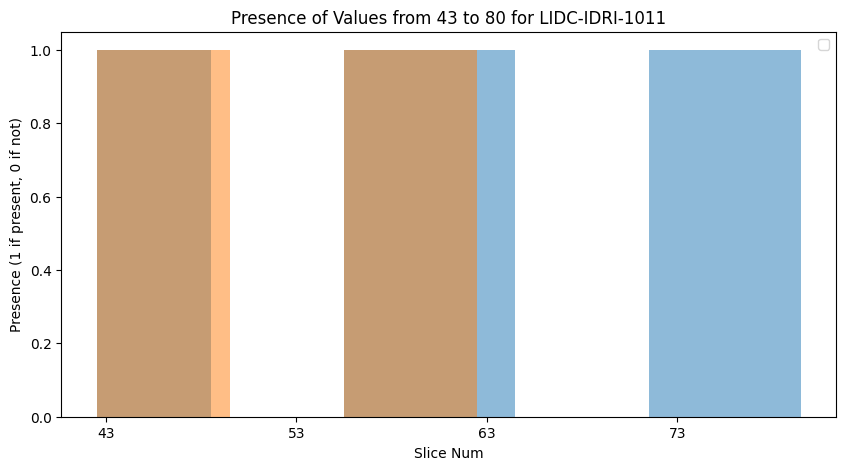

In [81]:
# Determines max y value to show on graph
y_min = combined[0][0]
y_max = combined[-1][0]

# Create an array of zeros for the range 0-200
label_presence = [0] * (y_max-y_min)
pred_presence = [0] * (y_max-y_min)

# Mark presence of each value in the list
for entry in combined:
    if entry[1] != []:
        pred_presence[entry[0]-y_max] = 1
    if entry[2] != []:
        label_presence[entry[0]-y_max] = 1

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(range(y_min, y_max), label_presence, width=1.0, alpha=.5)
plt.bar(range(y_min, y_max), pred_presence, width=1.0, alpha=.5)
plt.xlabel('Slice Num')
plt.ylabel('Presence (1 if present, 0 if not)')
patient_id = path.split('_')[0].split('/')[-1]
plt.title(f'Presence of Values from {y_min} to {y_max} for {patient_id}')
plt.xticks(range(y_min, y_max, 10))
plt.legend()

plt.show()

In [ ]:
combined